In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
import matplotlib.pylab as pylab
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import tqdm
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
## tensorflow 2 ###

# Grid search
# import talos

df = pd.read_csv('/content/drive/My Drive/decompose_by_interest_4.csv')

# df = pd.read_csv('/content/drive/My Drive/decompose_by_attention_per_day.csv')
# df_at = pd.read_csv('/content/drive/My Drive/decompose_by_attention.csv')
# df_ca = pd.read_csv('/content/drive/My Drive/decompose_by_caution.csv')
# df_se = pd.read_csv('/content/drive/My Drive/decompose_by_serious.csv')

numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

print(df.shape)
df

(1471716, 38)


,datetime,fw,wl,wlobscd,ymdhm,observatory,interest,attention,caution,serious,...,paldang_4hour,paldang_6hour,paldang_8hour,paldang_10hour,paldang_12hour,rf_kangwon_4hour,rf_kangwon_6hour,rf_kangwon_8hour,rf_kangwon_10hour,rf_kangwon_12hour
0,2010-01-01 00:00:00,6.08,1.78,1018655,2010010100,Daegok Bridge,3.8,5.5,7.0,8.5,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
1,2010-01-01 01:00:00,6.08,1.78,1018655,2010010101,Daegok Bridge,3.8,5.5,7.0,8.5,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
2,2010-01-01 02:00:00,6.08,1.78,1018655,2010010102,Daegok Bridge,3.8,5.5,7.0,8.5,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
3,2010-01-01 03:00:00,6.08,1.78,1018655,2010010103,Daegok Bridge,3.8,5.5,7.0,8.5,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
4,2010-01-01 04:00:00,6.08,1.78,1018655,2010010104,Daegok Bridge,3.8,5.5,7.0,8.5,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471711,2023-12-31 19:00:00,128.90,1.13,1018640,2023123119,Gwangjin Bridge,3.0,8.0,10.5,13.6,...,0.200,11.507,130.316,129.862,0.200,0.0,0.0,0.0,0.8,0.0
1471712,2023-12-31 20:00:00,124.87,1.13,1018640,2023123120,Gwangjin Bridge,3.0,8.0,10.5,13.6,...,127.950,0.200,118.564,139.239,1.120,0.0,0.0,2.7,0.0,0.0
1471713,2023-12-31 21:00:00,124.87,1.13,1018640,2023123121,Gwangjin Bridge,3.0,8.0,10.5,13.6,...,142.493,0.200,11.507,130.316,129.862,0.0,0.0,0.0,0.0,0.8
1471714,2023-12-31 22:00:00,128.90,1.13,1018640,2023123122,Gwangjin Bridge,3.0,8.0,10.5,13.6,...,143.902,127.950,0.200,118.564,139.239,0.0,0.0,0.0,2.7,0.0


In [ ]:
warning_level = df[['observatory','interest','attention','caution','serious']]
warning_level = warning_level.drop_duplicates().reset_index(drop=True)
df.drop(['interest','attention','caution','serious'], axis=1, inplace=True)
warning_level

,observatory,interest,attention,caution,serious
0,Daegok Bridge,3.8,5.5,7.0,8.5
1,Ogeum Bridge,4.0,7.0,9.0,11.1
2,Neobu Bridge,1.5,3.0,4.0,4.8
3,Haengju Bridge,4.5,6.5,8.0,10.7
4,Daechi Bridge,3.0,8.5,11.0,13.5
5,Jamsu Bridge,3.9,5.5,6.2,6.5
6,Hangang Bridge,3.9,8.5,10.5,13.3
7,Wolgye 2 Bridge,2.0,5.0,6.0,6.2
8,Changdong Bridge,4.5,5.5,6.5,7.9
9,Cheongdam Bridge,3.0,9.0,11.5,16.0


In [ ]:
from sklearn.preprocessing import StandardScaler

# StandardScaler를 사용하여 데이터 정규화

col = ['wl', 'fw', 'rf_seoul', 'rf_kangwon_4hour', 'chungju_4hour','paldang_4hour', 'residual','seasonal','trend']

scaler = StandardScaler()
scaler.fit(df[col])

# 원래 데이터의 평균과 표준편차 저장
mean_values = scaler.mean_
std_values = scaler.scale_

# 데이터 정규화
df[col] = scaler.transform(df[col])
df

,datetime,fw,wl,wlobscd,ymdhm,observatory,latitude,longitude,date,year,...,paldang_4hour,paldang_6hour,paldang_8hour,paldang_10hour,paldang_12hour,rf_kangwon_4hour,rf_kangwon_6hour,rf_kangwon_8hour,rf_kangwon_10hour,rf_kangwon_12hour
0,2010-01-01 00:00:00,-0.331132,0.565010,1018655,2010010100,Daegok Bridge,37.468742,127.122572,2010-01-01,2010,...,-0.247182,0.000,0.000,0.000,0.000,-0.126371,0.0,0.0,0.0,0.0
1,2010-01-01 01:00:00,-0.331132,0.565010,1018655,2010010101,Daegok Bridge,37.468742,127.122572,2010-01-01,2010,...,-0.247182,0.000,0.000,0.000,0.000,-0.126371,0.0,0.0,0.0,0.0
2,2010-01-01 02:00:00,-0.331132,0.565010,1018655,2010010102,Daegok Bridge,37.468742,127.122572,2010-01-01,2010,...,-0.247182,0.000,0.000,0.000,0.000,-0.126371,0.0,0.0,0.0,0.0
3,2010-01-01 03:00:00,-0.331132,0.565010,1018655,2010010103,Daegok Bridge,37.468742,127.122572,2010-01-01,2010,...,-0.247182,0.000,0.000,0.000,0.000,-0.126371,0.0,0.0,0.0,0.0
4,2010-01-01 04:00:00,-0.331132,0.565010,1018655,2010010104,Daegok Bridge,37.468742,127.122572,2010-01-01,2010,...,-0.247182,0.000,0.000,0.000,0.000,-0.126371,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471711,2023-12-31 19:00:00,-0.168469,-0.165684,1018640,2023123119,Gwangjin Bridge,37.542950,127.113154,2023-12-31,2023,...,-0.246257,11.507,130.316,129.862,0.200,-0.126371,0.0,0.0,0.8,0.0
1471712,2023-12-31 20:00:00,-0.173806,-0.165684,1018640,2023123120,Gwangjin Bridge,37.542950,127.113154,2023-12-31,2023,...,0.344460,0.200,118.564,139.239,1.120,-0.126371,0.0,2.7,0.0,0.0
1471713,2023-12-31 21:00:00,-0.173806,-0.165684,1018640,2023123121,Gwangjin Bridge,37.542950,127.113154,2023-12-31,2023,...,0.411707,0.200,11.507,130.316,129.862,-0.126371,0.0,0.0,0.0,0.8
1471714,2023-12-31 22:00:00,-0.168469,-0.165684,1018640,2023123122,Gwangjin Bridge,37.542950,127.113154,2023-12-31,2023,...,0.418222,127.950,0.200,118.564,139.239,-0.126371,0.0,0.0,2.7,0.0


In [ ]:
# 변환된 값을 다시 원래 값으로 되돌리기 위한 함수 정의
def inverse_transform_standardized(scaled_values, mean_values, std_values):
    original_values = scaled_values * std_values + mean_values
    return original_values

In [ ]:
print(mean_values, std_values)

[ 1.27738643e+00  2.56104250e+02  1.57709776e-01  1.52464470e-01
  4.40423558e+02  5.34562231e+01 -4.11243865e-04 -2.23388255e-06
  1.27668000e+00] [8.89565508e-01 7.55059728e+02 1.32977013e+00 1.20648773e+00
 9.96574979e+02 2.16262651e+02 3.35827131e-01 1.91443848e-01
 7.66152213e-01]


In [ ]:

lossmetric = 'mean_absolute_error'
sequence_length = 8
dropae = 0.1

In [ ]:
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]


def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

In [ ]:
### CREATE TRAIN/TEST DATA ###
X, y = [], []
for sequence in gen_sequence(df[df["observatory"] == 'Gwangjin Bridge'], sequence_length, ['wl']):
    X.append(sequence)
X = np.asarray(X)

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

for sequence in gen_labels(df[df["observatory"] == 'Gwangjin Bridge'], sequence_length, ['wl']):
    y.append(sequence)
y = np.asarray(y)
y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)

# X = df.drop(['wl'], axis=1)
# y = df['wl']
# X_train , X_test = train_test_split(X, train_size=0.8, random_state=42)
# y_train , y_test = train_test_split(y, train_size=0.8, random_state=42)

In [ ]:
# X_train = np.asarray(X_train)
# X_test = np.asarray(X_test)
# y_train = []
# y_test = []
# y_other_train = []
# y_other_test = []

# for bridge in df["observatory"].unique():
#     for sequence in gen_sequence(df[df["observatory"] == bridge], sequence_length, ['wl']):
#         if bridge in trainBridge:
#             y_train.append(sequence)
#     for sequence in gen_sequence(df[df["observatory"] == bridge], sequence_length, ['wl']):
#         if bridge in testBridge:
#             y_test.append(sequence)

In [ ]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [ ]:
from datetime import datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df

,datetime,fw,wl,wlobscd,ymdhm,observatory,latitude,longitude,date,year,...,paldang_4hour,paldang_6hour,paldang_8hour,paldang_10hour,paldang_12hour,rf_kangwon_4hour,rf_kangwon_6hour,rf_kangwon_8hour,rf_kangwon_10hour,rf_kangwon_12hour
0,2010-01-01 00:00:00,-0.331132,0.565010,1018655,2010010100,Daegok Bridge,37.468742,127.122572,2010-01-01,2010,...,-0.247182,0.000,0.000,0.000,0.000,-0.126371,0.0,0.0,0.0,0.0
1,2010-01-01 01:00:00,-0.331132,0.565010,1018655,2010010101,Daegok Bridge,37.468742,127.122572,2010-01-01,2010,...,-0.247182,0.000,0.000,0.000,0.000,-0.126371,0.0,0.0,0.0,0.0
2,2010-01-01 02:00:00,-0.331132,0.565010,1018655,2010010102,Daegok Bridge,37.468742,127.122572,2010-01-01,2010,...,-0.247182,0.000,0.000,0.000,0.000,-0.126371,0.0,0.0,0.0,0.0
3,2010-01-01 03:00:00,-0.331132,0.565010,1018655,2010010103,Daegok Bridge,37.468742,127.122572,2010-01-01,2010,...,-0.247182,0.000,0.000,0.000,0.000,-0.126371,0.0,0.0,0.0,0.0
4,2010-01-01 04:00:00,-0.331132,0.565010,1018655,2010010104,Daegok Bridge,37.468742,127.122572,2010-01-01,2010,...,-0.247182,0.000,0.000,0.000,0.000,-0.126371,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471711,2023-12-31 19:00:00,-0.168469,-0.165684,1018640,2023123119,Gwangjin Bridge,37.542950,127.113154,2023-12-31,2023,...,-0.246257,11.507,130.316,129.862,0.200,-0.126371,0.0,0.0,0.8,0.0
1471712,2023-12-31 20:00:00,-0.173806,-0.165684,1018640,2023123120,Gwangjin Bridge,37.542950,127.113154,2023-12-31,2023,...,0.344460,0.200,118.564,139.239,1.120,-0.126371,0.0,2.7,0.0,0.0
1471713,2023-12-31 21:00:00,-0.173806,-0.165684,1018640,2023123121,Gwangjin Bridge,37.542950,127.113154,2023-12-31,2023,...,0.411707,0.200,11.507,130.316,129.862,-0.126371,0.0,0.0,0.0,0.8
1471714,2023-12-31 22:00:00,-0.168469,-0.165684,1018640,2023123122,Gwangjin Bridge,37.542950,127.113154,2023-12-31,2023,...,0.418222,127.950,0.200,118.564,139.239,-0.126371,0.0,0.0,2.7,0.0


In [ ]:
df['year'].unique()
splitTest = 5105
customXLabel = []
for j in range(len(df['year'].unique())-1):
    j = j*12
    customXLabel.append(j)
customXLabel

[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144]

In [ ]:
### CONCATENATE TRAIN/TEST DATA AND LABEL ###
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

In [ ]:
F = []

for sequence in gen_sequence(df[df['observatory']=='Gwangjin Bridge'], sequence_length, col):
    F.append(sequence)
F = np.asarray(F)
f_train, f_test = train_test_split(F, test_size=0.2, random_state=42)

In [ ]:
f_train = np.asarray(f_train)
f_test = np.asarray(f_test)

F = np.concatenate([f_train,f_test], axis=0)

In [ ]:
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)
print(F.shape, f_train.shape, f_test.shape)

(122635, 8, 1) (98108, 8, 1) (24527, 8, 1)
(122635, 1) (98108, 1) (24527, 1)
(122635, 8, 9) (98108, 8, 9) (24527, 8, 9)


In [ ]:
### SET SEED ###
os.environ['PYTHONHASHSEED'] = str(47)
np.random.seed(47)
random.seed(47)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(),
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
### LSTM AUTOENCODER ###
inputsAE = Input(shape=(sequence_length, 1))

encodedAE = GRU(128, return_sequences=True, dropout=dropae)(inputsAE, training=True)

decodedAE = GRU(32, return_sequences=True, dropout=dropae)(encodedAE, training=True)

outputAE = TimeDistributed(Dense(1))(decodedAE)

sequenceAE = Model(inputsAE, outputAE)
sequenceAE.compile(optimizer='adam', loss=lossmetric, metrics=[lossmetric])

In [ ]:
### TRAIN AUTOENCODER ###
sequenceAE.fit(X[:len(X_train)], X[:len(X_train)], batch_size=128, epochs=30, verbose=2, shuffle=False)

os.environ['PYTHONHASHSEED'] = str(47)
np.random.seed(47)
random.seed(47)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(),
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

Epoch 1/30
767/767 - 8s - loss: 0.0316 - mean_absolute_error: 0.0316 - 8s/epoch - 10ms/step
Epoch 2/30
767/767 - 3s - loss: 0.0206 - mean_absolute_error: 0.0206 - 3s/epoch - 4ms/step
Epoch 3/30
767/767 - 3s - loss: 0.0160 - mean_absolute_error: 0.0160 - 3s/epoch - 4ms/step
Epoch 4/30
767/767 - 3s - loss: 0.0143 - mean_absolute_error: 0.0143 - 3s/epoch - 4ms/step
Epoch 5/30
767/767 - 3s - loss: 0.0122 - mean_absolute_error: 0.0122 - 3s/epoch - 4ms/step
Epoch 6/30
767/767 - 3s - loss: 0.0104 - mean_absolute_error: 0.0104 - 3s/epoch - 4ms/step
Epoch 7/30
767/767 - 3s - loss: 0.0096 - mean_absolute_error: 0.0096 - 3s/epoch - 4ms/step
Epoch 8/30
767/767 - 3s - loss: 0.0092 - mean_absolute_error: 0.0092 - 3s/epoch - 4ms/step
Epoch 9/30
767/767 - 3s - loss: 0.0089 - mean_absolute_error: 0.0089 - 3s/epoch - 4ms/step
Epoch 10/30
767/767 - 3s - loss: 0.0085 - mean_absolute_error: 0.0085 - 3s/epoch - 4ms/step
Epoch 11/30
767/767 - 3s - loss: 0.0084 - mean_absolute_error: 0.0084 - 3s/epoch - 4ms/s

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, TimeDistributed
from sklearn.preprocessing import StandardScaler
import kerastuner as kt
import matplotlib.pyplot as plt

# 고정된 시드 값 설정
os.environ['PYTHONHASHSEED'] = str(47)
np.random.seed(47)
random.seed(47)
tf.random.set_seed(47)

# 모델 생성 함수 정의
def build_model(hp):
    dropOut = hp.Choice('dropOut', values=[0.2, 0.5])
    lstmcell1 = hp.Choice('lstmcell1', values=[64, 128, 256])
    lstmcell2 = hp.Choice('lstmcell2', values=[64, 128])
    dense1 = hp.Choice('dense1', values=[32, 64])
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])

    inputs1 = Input(shape=(X_train1.shape[1], X_train1.shape[2]))
    lstm1 = GRU(lstmcell1, return_sequences=True, dropout=dropOut)(inputs1, training=True)
    lstm1 = GRU(lstmcell2, return_sequences=False, dropout=dropOut)(lstm1, training=True)
    dense1 = Dense(dense1)(lstm1)
    out1 = Dense(1)(dense1)

    model = Model(inputs1, out1)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    return model


In [ ]:
# 데이터 전처리
encoder = Model(inputsAE, encodedAE)
XX = encoder.predict(X)
XXF = np.concatenate([XX, F], axis=2)

X_train1, X_test1 = XXF[:len(X_train)], XXF[len(X_train):]
y_train1, y_test1 = y[:len(y_train)], y[len(y_train):]

scaler1 = StandardScaler()

X_train1 = scaler1.fit_transform(X_train1.reshape(-1, XXF.shape[-1])).reshape(-1, sequence_length, XXF.shape[-1])
X_test1 = scaler1.transform(X_test1.reshape(-1, XXF.shape[-1])).reshape(-1, sequence_length, XXF.shape[-1])


3833/3833 [==============================] - 6s 1ms/step


In [ ]:
# Keras Tuner 설정 및 실행
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=50,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

train_size = int(len(X_train1) * 0.8)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train1[:train_size], y_train1[:train_size],
             epochs=50,
             validation_data=(X_train1[train_size:], y_train1[train_size:]),
             callbacks=[stop_early])

# 최적의 하이퍼파라미터 출력
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of lstmcell1 is {best_hps.get('lstmcell1')}.
The optimal number of lstmcell2 is {best_hps.get('lstmcell2')}.
The optimal number of dense1 is {best_hps.get('dense1')}.
The optimal dropout rate is {best_hps.get('dropOut')}.
The optimal optimizer is {best_hps.get('optimizer')}.
""")


Trial 63 Complete [00h 01m 23s]
val_loss: 0.002235513413324952

Best val_loss So Far: 0.001181086990982294
Total elapsed time: 01h 00m 48s

The optimal number of lstmcell1 is 128.
The optimal number of lstmcell2 is 128.
The optimal number of dense1 is 32.
The optimal dropout rate is 0.2.
The optimal optimizer is rmsprop.



Epoch 1/200
307/307 - 5s - loss: 0.0284 - accuracy: 0.0000e+00 - val_loss: 0.0123 - val_accuracy: 0.0000e+00 - 5s/epoch - 17ms/step
Epoch 2/200
307/307 - 2s - loss: 0.0074 - accuracy: 0.0000e+00 - val_loss: 0.0064 - val_accuracy: 0.0000e+00 - 2s/epoch - 5ms/step
Epoch 3/200
307/307 - 2s - loss: 0.0052 - accuracy: 0.0000e+00 - val_loss: 0.0044 - val_accuracy: 0.0000e+00 - 2s/epoch - 5ms/step
Epoch 4/200
307/307 - 2s - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00 - 2s/epoch - 5ms/step
Epoch 5/200
307/307 - 2s - loss: 0.0038 - accuracy: 0.0000e+00 - val_loss: 0.0052 - val_accuracy: 0.0000e+00 - 2s/epoch - 5ms/step
Epoch 6/200
307/307 - 2s - loss: 0.0032 - accuracy: 0.0000e+00 - val_loss: 0.0050 - val_accuracy: 0.0000e+00 - 2s/epoch - 5ms/step
Epoch 7/200
307/307 - 2s - loss: 0.0030 - accuracy: 0.0000e+00 - val_loss: 0.0064 - val_accuracy: 0.0000e+00 - 2s/epoch - 5ms/step
Epoch 8/200
307/307 - 2s - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0057 

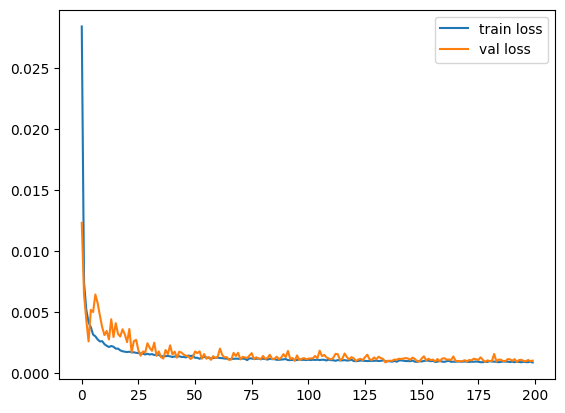

In [ ]:
# 최적의 하이퍼파라미터로 모델 재학습
model1 = tuner.hypermodel.build(best_hps)
epochs = best_hps.get('epochs') if 'epochs' in best_hps.values else 200
batch_size = best_hps.get('batch_size') if 'batch_size' in best_hps.values else 256

history = model1.fit(X_train1[:train_size], y_train1[:train_size],
                     validation_data=(X_train1[train_size:], y_train1[train_size:]),
                     epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

# 학습 결과 시각화
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
# 최적의 모델로 예측
predictions = model1.predict(X_test1)

# 예측값을 원래 스케일로 복원
# predictions = scaler1.inverse_transform(predictions.reshape(-1, 1))


767/767 [==============================] - 2s 2ms/step


In [ ]:
def test_other_drop1(X_test, y_test, f_test, enc, NN):
    X = X_test
    F = f_test
    y = y_test
    enc_pred = np.vstack(enc([X]))
    enc_pred = np.concatenate([enc_pred, F], axis=2)

    trans_pred = scaler1.transform(enc_pred.reshape(-1, enc_pred.shape[-1])).reshape(-1, sequence_length, enc_pred.shape[-1])
    NN_pred = NN([trans_pred])

    return np.vstack(NN_pred), y

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    common_indices = np.intersect1d(y_true.index, y_pred.index)
    y_true = y_true.loc[common_indices]
    y_pred = y_pred.loc[common_indices]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
          'axes.labelsize': '15',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': '18',
          'ytick.labelsize': '22'}
pylab.rcParams.update(params)

In [ ]:
# f_test = []
# col = ['residual', "seasonal", 'trend', 'anomalies']
# for bridge in df["observatory"].unique():
#   for sequence in gen_sequence(df[df["observatory"] == bridge],sequence_length, col):
#     if bridge == 'Jamsu Bridge':
#       f_test.append(sequence)

# f_test = np.asarray(f_test)
# f_test.shape

In [ ]:
# testBridge = ['Jamsu Bridge']


In [ ]:
# def minmax_inverse_normalized(x_normalized, min_val, max_val):
#     x = (x_normalized * (max_val - min_val)) + min_val
#     return x

In [ ]:
data = df
data.set_index('datetime', inplace=True)
data

,fw,wl,wlobscd,ymdhm,observatory,latitude,longitude,date,year,month,...,paldang_4hour,paldang_6hour,paldang_8hour,paldang_10hour,paldang_12hour,rf_kangwon_4hour,rf_kangwon_6hour,rf_kangwon_8hour,rf_kangwon_10hour,rf_kangwon_12hour
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,-0.331132,0.565010,1018655,2010010100,Daegok Bridge,37.468742,127.122572,2010-01-01,2010,1,...,-0.247182,0.000,0.000,0.000,0.000,-0.126371,0.0,0.0,0.0,0.0
2010-01-01 01:00:00,-0.331132,0.565010,1018655,2010010101,Daegok Bridge,37.468742,127.122572,2010-01-01,2010,1,...,-0.247182,0.000,0.000,0.000,0.000,-0.126371,0.0,0.0,0.0,0.0
2010-01-01 02:00:00,-0.331132,0.565010,1018655,2010010102,Daegok Bridge,37.468742,127.122572,2010-01-01,2010,1,...,-0.247182,0.000,0.000,0.000,0.000,-0.126371,0.0,0.0,0.0,0.0
2010-01-01 03:00:00,-0.331132,0.565010,1018655,2010010103,Daegok Bridge,37.468742,127.122572,2010-01-01,2010,1,...,-0.247182,0.000,0.000,0.000,0.000,-0.126371,0.0,0.0,0.0,0.0
2010-01-01 04:00:00,-0.331132,0.565010,1018655,2010010104,Daegok Bridge,37.468742,127.122572,2010-01-01,2010,1,...,-0.247182,0.000,0.000,0.000,0.000,-0.126371,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,-0.168469,-0.165684,1018640,2023123119,Gwangjin Bridge,37.542950,127.113154,2023-12-31,2023,12,...,-0.246257,11.507,130.316,129.862,0.200,-0.126371,0.0,0.0,0.8,0.0
2023-12-31 20:00:00,-0.173806,-0.165684,1018640,2023123120,Gwangjin Bridge,37.542950,127.113154,2023-12-31,2023,12,...,0.344460,0.200,118.564,139.239,1.120,-0.126371,0.0,2.7,0.0,0.0
2023-12-31 21:00:00,-0.173806,-0.165684,1018640,2023123121,Gwangjin Bridge,37.542950,127.113154,2023-12-31,2023,12,...,0.411707,0.200,11.507,130.316,129.862,-0.126371,0.0,0.0,0.0,0.8


(61314, 8, 1)
(61314, 1)
(61314, 8, 9)
(61314, 8, 1) (61314, 1) (61314, 8, 9)


100%|██████████| 100/100 [02:53<00:00,  1.74s/it]


	R-squared : 0.9899 (Mean) 0.0004 (Standard Error)
	MAE : 0.0211 (Mean) 0.0001 (Standard Error)
	MSE : 0.0012 (Mean) 0.0000 (Standard Error)
	RMSE : 0.0339 (Mean) 0.0006 (Standard Error)


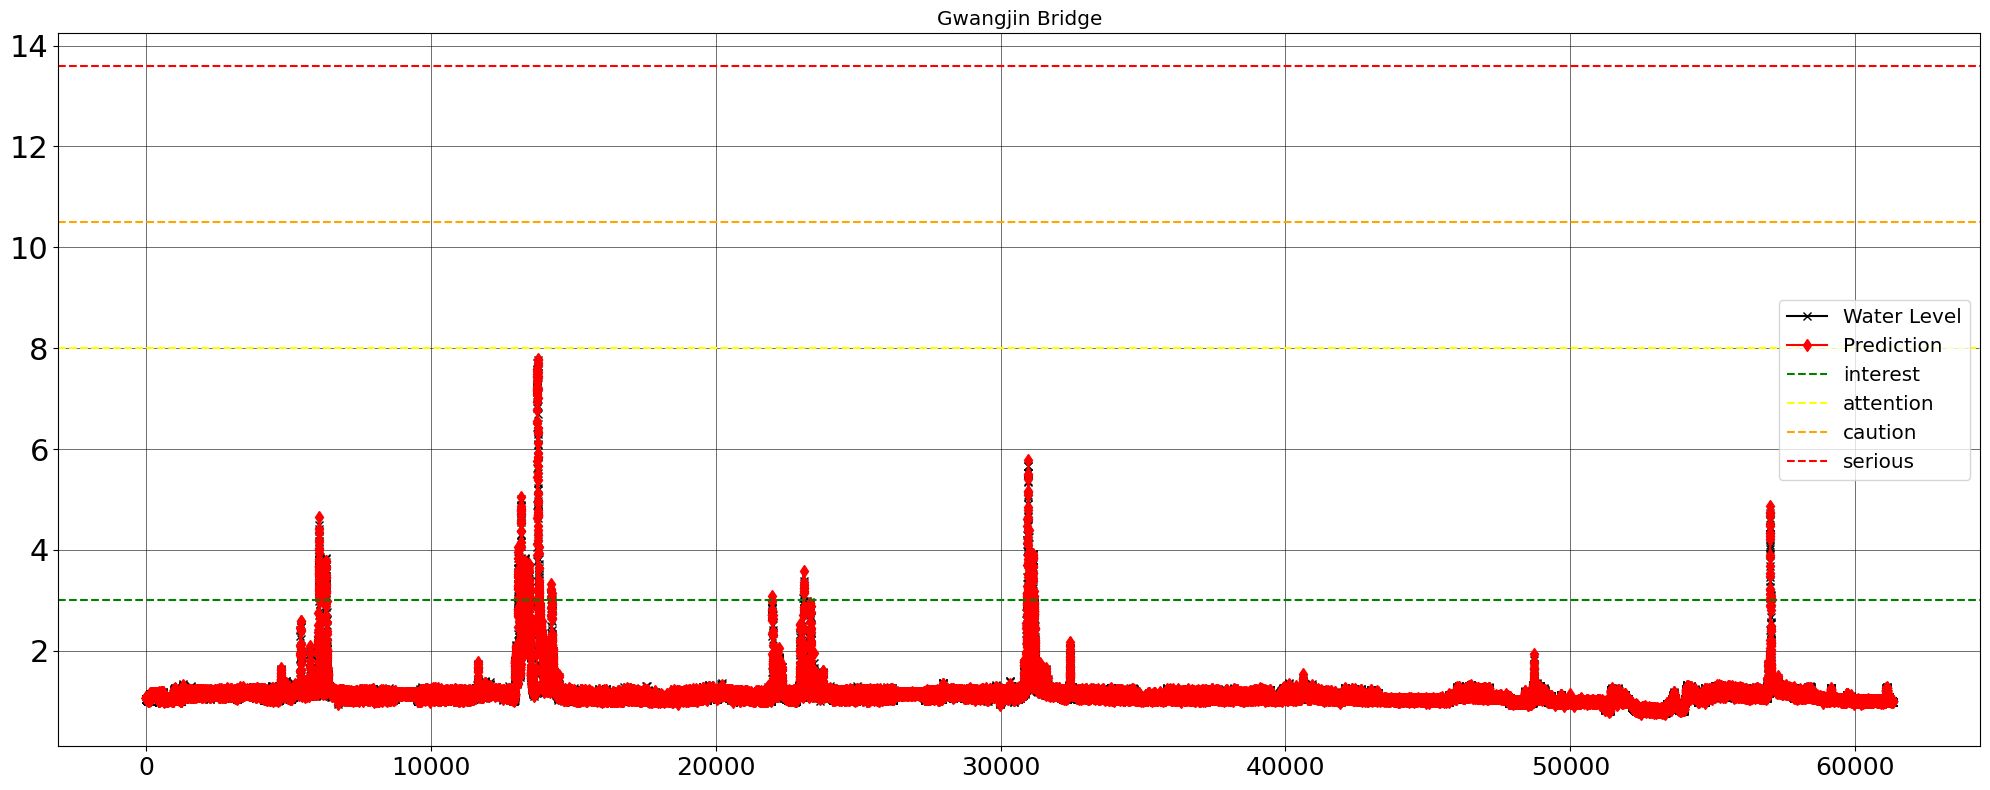

In [ ]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score

submission_list = []
inversed_submission_list = []

bridge_name = 'Gwangjin Bridge'
# b = df[(df["observatory"] == j)]

X_test = []
y_test = []
f_test = []
sequence_length = 8
df = data[data['year'] <= 2016]

### X_test ###
for sequence in gen_sequence(df[df['observatory']=='Gwangjin Bridge'],sequence_length, ['wl']):
    X_test.append(sequence)
X_test = np.asarray(X_test)
print(X_test.shape)

for sequence in gen_labels(df[df['observatory']=='Gwangjin Bridge'],sequence_length, ['wl']):
    y_test.append(sequence)
y_test = np.asarray(y_test)
print(y_test.shape)

### f_test ###
for sequence in gen_sequence(df[df['observatory']=='Gwangjin Bridge'],sequence_length, col):
    f_test.append(sequence)
f_test = np.asarray(f_test)
print(f_test.shape)

print(X_test.shape, y_test.shape, f_test.shape)

R2, MAE, MSE, RMSE = [], [], [] ,[]
trueValuesList = []

enc = K.function([encoder.layers[0].input], [encoder.layers[-1].output])
NN = K.function([model1.layers[0].input], [model1.layers[-1].output])

for i in tqdm.tqdm(range(0, 100)):
    predictedValues, trueValues = test_other_drop1(X_test, y_test, f_test, enc, NN)
    R2.append(r2_score(predictedValues, trueValues))
    MAE.append(mean_absolute_error(predictedValues, trueValues))
    MSE.append(mean_squared_error(predictedValues, trueValues))
    RMSE.append(np.sqrt(mean_squared_error(predictedValues, trueValues)))
    trueValuesList.append(trueValues)

print("\tR-squared : %.4f (Mean) %.4f (Standard Error)" % (np.mean(R2), np.std(R2)))
print("\tMAE : %.4f (Mean) %.4f (Standard Error)" % (np.mean(MAE), np.std(MAE)))
print("\tMSE : %.4f (Mean) %.4f (Standard Error)" % (np.mean(MSE), np.std(MSE)))
print("\tRMSE : %.4f (Mean) %.4f (Standard Error)" % (np.mean(RMSE), np.std(RMSE)))

#### 그래프 그리기 ####
plt.rcParams['figure.figsize'] = 20, 8
f, ax = plt.subplots()

submission = pd.DataFrame(index=df[df['observatory'] == bridge_name].index[sequence_length:])
submission['true'] = trueValues.flatten()
submission['predict'] = predictedValues.flatten()
submission['bridge_name'] = [bridge_name for _ in range(len(trueValues))]
submission_list.append(submission)

inverse_true = inverse_transform_standardized(np.mean(np.hstack(trueValuesList).T, axis=0), mean_values[0], std_values[0])
ax.plot(inverse_true, color='black', label='Water Level', marker='x')

inverse_predict = inverse_transform_standardized(predictedValues, mean_values[0], std_values[0])
ax.plot(inverse_predict, color='red', label="Prediction", marker='d')

ax.set_title(bridge_name)

w = warning_level[warning_level['observatory'] == bridge_name]

inversed_submission = pd.DataFrame(index=df[df['observatory'] == bridge_name].index[sequence_length:])
inversed_submission['true'] = inverse_true.flatten()
inversed_submission['predict'] = inverse_predict.flatten()
inversed_submission['bridge_name'] = [bridge_name for _ in range(len(inverse_true))]
inversed_submission['anomaly'] = inversed_submission['true'] > w['interest'].iloc[0]
inversed_submission_list.append(inversed_submission)

ax.axhline(y=w['interest'].item(), color='green', linestyle='--', label='interest')
ax.axhline(y=w['attention'].item(), color='yellow', linestyle='--', label='attention')
ax.axhline(y=w['caution'].item(), color='orange', linestyle='--', label='caution')
ax.axhline(y=w['serious'].item(), color='red', linestyle='--', label='serious')

ax.legend()

plt.grid(color='k', linestyle='-', linewidth=0.4)
plt.tight_layout()
plt.show()
x = 0


(61313, 8, 1)
(61313, 1)
(61313, 8, 9)
(61313, 8, 1) (61313, 1) (61313, 8, 9)


100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


	R-squared : 0.9928 (Mean) 0.0002 (Standard Error)
	MAE : 0.0185 (Mean) 0.0001 (Standard Error)
	MSE : 0.0010 (Mean) 0.0000 (Standard Error)
	RMSE : 0.0323 (Mean) 0.0005 (Standard Error)


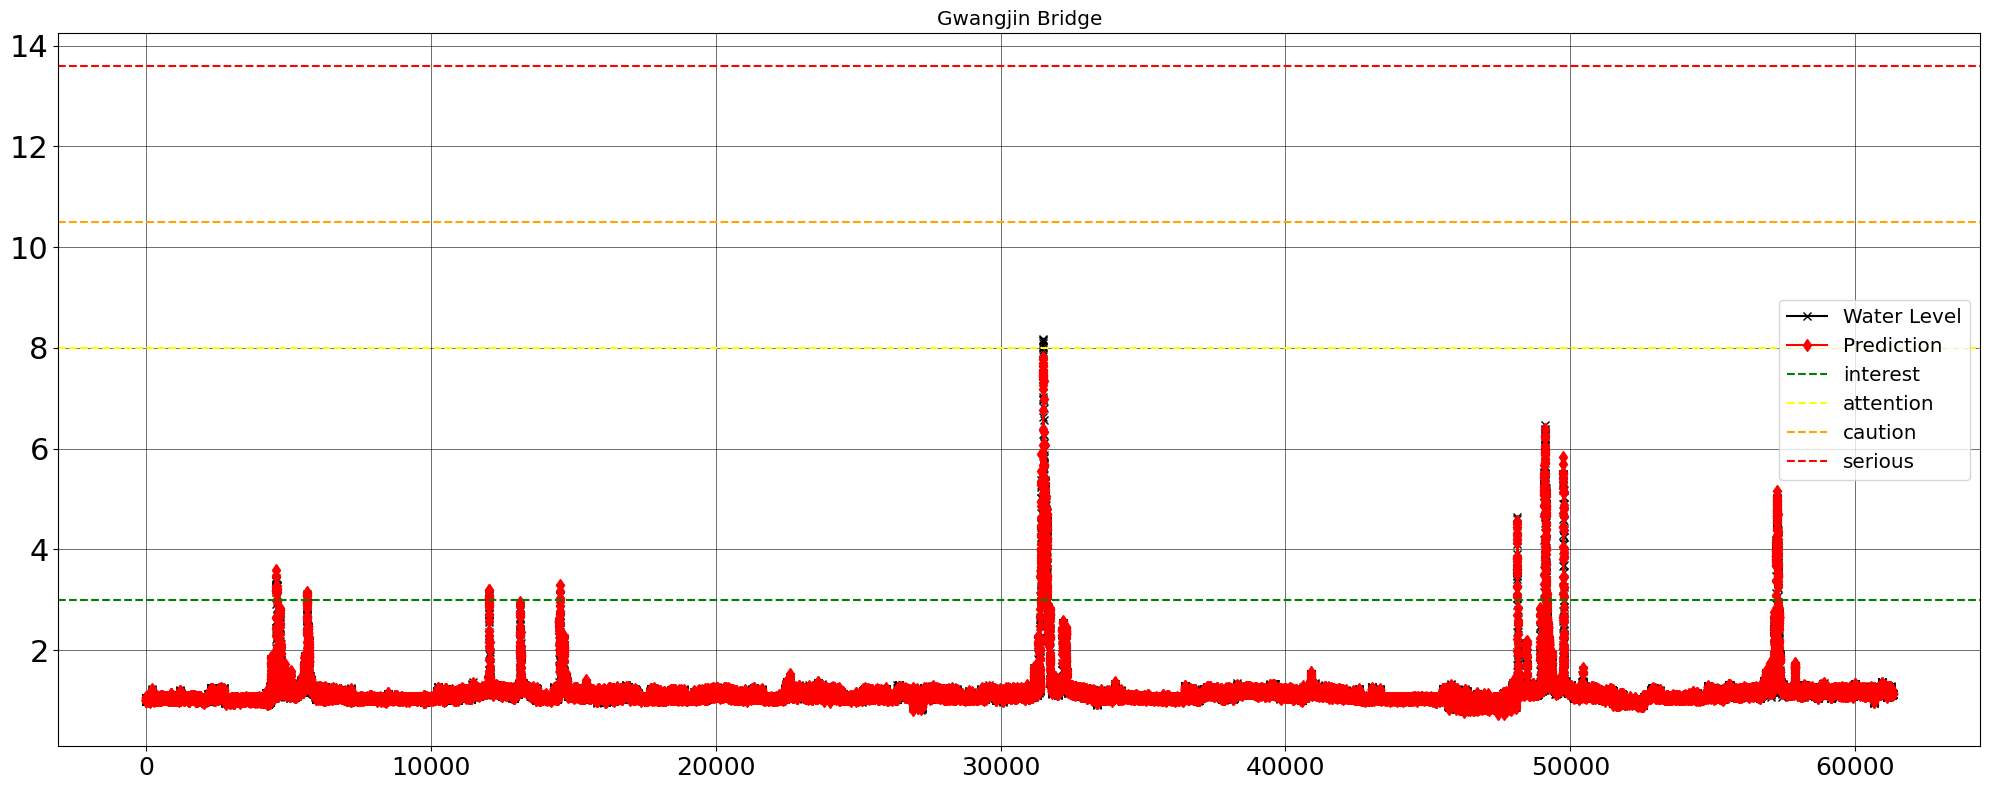

In [ ]:
bridge_name = 'Gwangjin Bridge'
# b = df[(df["observatory"] == j)]

X_test = []
y_test = []
f_test = []
sequence_length = 8
df = data[data['year'] > 2016]
### X_test ###
for sequence in gen_sequence(df[df['observatory']=='Gwangjin Bridge'],sequence_length, ['wl']):
    X_test.append(sequence)
X_test = np.asarray(X_test)
print(X_test.shape)

for sequence in gen_labels(df[df['observatory']=='Gwangjin Bridge'],sequence_length, ['wl']):
    y_test.append(sequence)
y_test = np.asarray(y_test)
print(y_test.shape)

### f_test ###
for sequence in gen_sequence(df[df['observatory']=='Gwangjin Bridge'],sequence_length, col):
    f_test.append(sequence)
f_test = np.asarray(f_test)
print(f_test.shape)

print(X_test.shape, y_test.shape, f_test.shape)

R2, MAE, MSE, RMSE = [], [], [] ,[]
trueValuesList = []

enc = K.function([encoder.layers[0].input], [encoder.layers[-1].output])
NN = K.function([model1.layers[0].input], [model1.layers[-1].output])

for i in tqdm.tqdm(range(0, 100)):
    predictedValues, trueValues = test_other_drop1(X_test, y_test, f_test, enc, NN)
    R2.append(r2_score(predictedValues, trueValues))
    MAE.append(mean_absolute_error(predictedValues, trueValues))
    MSE.append(mean_squared_error(predictedValues, trueValues))
    RMSE.append(np.sqrt(mean_squared_error(predictedValues, trueValues)))
    trueValuesList.append(trueValues)

print("\tR-squared : %.4f (Mean) %.4f (Standard Error)" % (np.mean(R2), np.std(R2)))
print("\tMAE : %.4f (Mean) %.4f (Standard Error)" % (np.mean(MAE), np.std(MAE)))
print("\tMSE : %.4f (Mean) %.4f (Standard Error)" % (np.mean(MSE), np.std(MSE)))
print("\tRMSE : %.4f (Mean) %.4f (Standard Error)" % (np.mean(RMSE), np.std(RMSE)))

#### 그래프 그리기 ####
plt.rcParams['figure.figsize'] = 20, 8
f, ax = plt.subplots()

submission = pd.DataFrame(index=df[df['observatory'] == bridge_name].index[sequence_length:])
submission['true'] = trueValues.flatten()
submission['predict'] = predictedValues.flatten()
submission['bridge_name'] = [bridge_name for _ in range(len(trueValues))]
submission_list.append(submission)

inverse_true = inverse_transform_standardized(np.mean(np.hstack(trueValuesList).T, axis=0), mean_values[0], std_values[0])
ax.plot(inverse_true, color='black', label='Water Level', marker='x')

inverse_predict = inverse_transform_standardized(predictedValues, mean_values[0], std_values[0])
ax.plot(inverse_predict, color='red', label="Prediction", marker='d')

ax.set_title(bridge_name)

w = warning_level[warning_level['observatory'] == bridge_name]

inversed_submission = pd.DataFrame(index=df[df['observatory'] == bridge_name].index[sequence_length:])
inversed_submission['true'] = inverse_true.flatten()
inversed_submission['predict'] = inverse_predict.flatten()
inversed_submission['bridge_name'] = [bridge_name for _ in range(len(inverse_true))]
inversed_submission['anomaly'] = inversed_submission['true'] > w['interest'].iloc[0]
inversed_submission_list.append(inversed_submission)

ax.axhline(y=w['interest'].item(), color='green', linestyle='--', label='interest')
ax.axhline(y=w['attention'].item(), color='yellow', linestyle='--', label='attention')
ax.axhline(y=w['caution'].item(), color='orange', linestyle='--', label='caution')
ax.axhline(y=w['serious'].item(), color='red', linestyle='--', label='serious')

ax.legend()

plt.grid(color='k', linestyle='-', linewidth=0.4)
plt.tight_layout()
# plt.savefig('[interest]' + bridge_name +'_DropOut_'+str(dropOut) + 'only daegyo '+'.png')
plt.show()
x = 0


In [ ]:
import pandas as pd
submission = pd.concat(submission_list)
inversed_submission = pd.concat(inversed_submission_list)

submission['anomaly'] = inversed_submission['anomaly']

submission.to_csv('scaled_submission_Gwangjin_10years_feature_inportance_gs_2(interest).csv', encoding='utf-8')
inversed_submission.to_csv('inversed_submission_Gwangjin_10years_feature_inportance_gs_2(interest).csv',encoding='utf-8')